In [1]:
import gc
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from scipy.stats import norm
import json
import datetime
# Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
# Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
init_notebook_mode(connected=True)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt
import lightgbm as lgb
import datetime
import seaborn as sns
from bayes_opt import BayesianOptimization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train_new.csv',dtype={ 'fullVisitorId': str}, nrows=None)
test = pd.read_csv('test_new.csv',dtype={'fullVisitorId': str}, nrows=None)

/Users/drucila/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning:

Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
train.shape, test.shape

((903653, 48), (903653, 46))

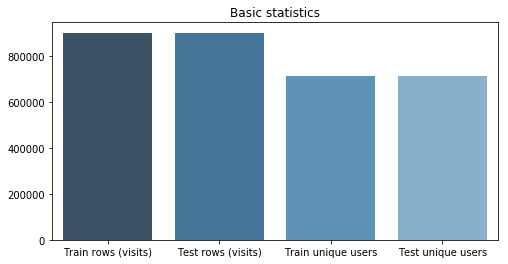

In [4]:
values_name = ['Train rows (visits)', 'Test rows (visits)', 'Train unique users', 'Test unique users']
values = [len(train), len(test), train['fullVisitorId'].nunique(), test['fullVisitorId'].nunique()]
plt.figure(figsize=(8,4))
plt.title("Basic statistics")
ax = sns.barplot(x=values_name, y=values, palette='Blues_d')

totals_transactionRevenue has 11515 non-missing values or 1.274% (train set)
Only 9996 unique users have transactions or 0.014% (train set)


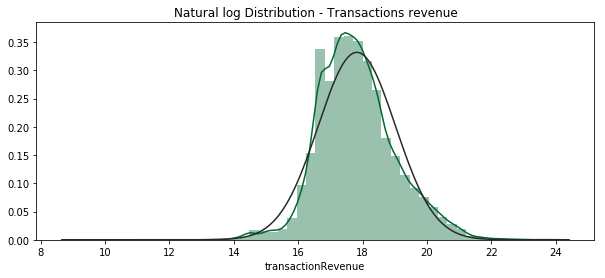

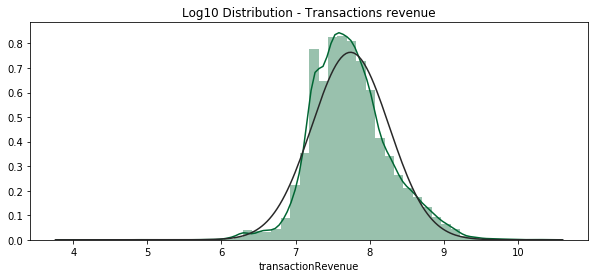

In [5]:
non_missing = len(train[~train['transactionRevenue'].isnull()])
num_visitors = train[~train['transactionRevenue'].isnull()]['fullVisitorId'].nunique()
print("totals_transactionRevenue has {} non-missing values or {:.3f}% (train set)"
      .format(non_missing, 100*non_missing/len(train)))
print("Only {} unique users have transactions or {:.3f}% (train set)"
      .format(num_visitors, num_visitors/train['fullVisitorId'].nunique()))
# Logn Distplot
revenue = train['transactionRevenue'].dropna().astype('float64')
plt.figure(figsize=(10,4))
plt.title("Natural log Distribution - Transactions revenue")
ax1 = sns.distplot(np.log(revenue), color="#006633", fit=norm)
# Log10 Distplot
plt.figure(figsize=(10,4))
plt.title("Log10 Distribution - Transactions revenue")
ax1 = sns.distplot(np.log10(revenue), color="#006633", fit=norm)

# Fill missing with 0 and convert to numerical
train['transactionRevenue'] = train['transactionRevenue'].fillna(0).astype('int64')

In [6]:
def convert_to_datetime(frame):
    frame['date'] = frame['date'].astype(str)
    frame['date'] = frame['date'].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    frame['date'] = pd.to_datetime(frame['date'])
    return frame

train = convert_to_datetime(train)
test = convert_to_datetime(test)

In [7]:
tmp_train = train['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp_train = tmp_train.rename(columns = {"date" : "visits"}).rename(columns = {"index" : "date"})
# Visits by time test
tmp_test = test['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp_test = tmp_test.rename(columns = {"date" : "visits"}).rename(columns = {"index" : "date"})
# Plot visits
trace1 = go.Scatter(x=tmp_train.date.astype(str), y=tmp_train.visits,
                    opacity = 0.8, line = dict(color = '#ff751a'), name= 'Train')
trace2 = go.Scatter(x=tmp_test.date.astype(str), y=tmp_test.visits,
                    opacity = 0.8, line = dict(color = '#75a3a3'), name= 'Test')
traces = [trace1, trace2]

layout = dict(
    title= "Visits by date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)

fig = dict(data= traces, layout=layout)
iplot(fig)


# Revenue by time
train_date_sum = train.groupby('date')['transactionRevenue'].sum().to_frame().reset_index()
# Plot
trace_date = go.Scatter(x=train_date_sum.date.astype(str), 
                        y=train_date_sum['transactionRevenue'].apply(lambda x: np.log(x)), opacity = 0.8)
layout = dict(
    title= "Log Revenue by date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)


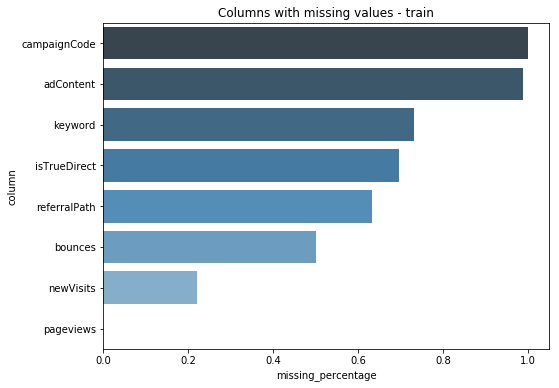

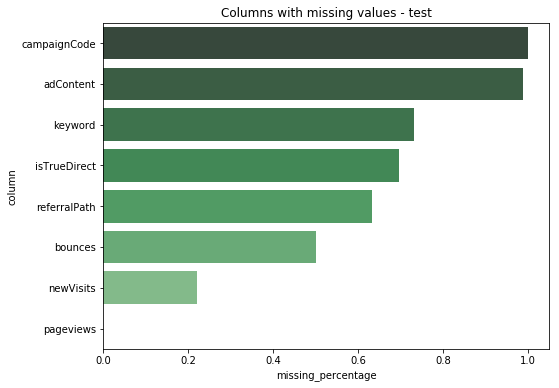

In [8]:
def missing_plot(frame, set_name, palette):
    nan_ratio = frame.isna().sum()/len(frame)
    nan_ratio = nan_ratio.to_frame().reset_index().rename({'index': 'column', 0: 'missing_percentage'},axis=1)
    nan_ratio.sort_values(by=['missing_percentage'], ascending=False, inplace=True)
    plt.figure(figsize=(8,6))
    plt.title("Columns with missing values - {}".format(set_name))
    ax = sns.barplot(x='missing_percentage', y='column', orient='h',
                     data=nan_ratio[nan_ratio['missing_percentage'] > 0],
                     palette= palette)

missing_plot(train, 'train', 'Blues_d')
missing_plot(train, 'test', 'Greens_d')

In [9]:
train_const_cols = [c for c in train.columns if len(train[c].unique()) == 1]
test_const_cols = [c for c in test.columns if len(test[c].unique()) == 1]
print("{} columns with a unique value on train set".format(len(train_const_cols)))
print("{} columns with a unique value on test set".format(len(test_const_cols)))
print("Same columns for train and test set: ", train_const_cols == test_const_cols)
train.drop(train_const_cols, axis=1, inplace=True)
test.drop(test_const_cols, axis=1, inplace=True)
print("Shape after dropping: train {}, test {}".format(train.shape, test.shape))
# Flag visits with revenue
train['has_revenue'] = train['transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)

18 columns with a unique value on train set
18 columns with a unique value on test set
Same columns for train and test set:  True
Shape after dropping: train (903653, 30), test (903653, 28)


In [10]:
def barplot_percentage(count_feat, color1= 'rgb(55, 83, 109)', 
                       color2= 'rgb(26, 118, 255)',num_bars= None):

    train_channel = 100*train[count_feat].value_counts()/len(train)
    train_channel = train_channel.to_frame().reset_index()
    test_channel = 100*test[count_feat].value_counts()/len(test)
    test_channel = test_channel.to_frame().reset_index()
    if num_bars:
        train_channel = train_channel.head(num_bars)
        test_channel = test_channel.head(num_bars)

    trace0 = go.Bar(
        x=train_channel['index'],
        y=train_channel[count_feat],
        name='Train set',
        marker=dict(color=color1)
    )
    trace1 = go.Bar(
        x=test_channel['index'],
        y=test_channel[count_feat],
        name='Test set',
        marker=dict(color=color2,)
    )

    layout = go.Layout(
        title='{} grouping'.format(count_feat),
        xaxis=dict(
            tickfont=dict(size=14, color='rgb(107, 107, 107)')
        ),
        yaxis=dict(
            title='Percentage of visits',
            titlefont=dict(size=16, color='rgb(107, 107, 107)'),
            tickfont=dict(size=14, color='rgb(107, 107, 107)')
        ),
        legend=dict(
            x=1.0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1
    )

    fig = go.Figure(data=[trace0, trace1], layout=layout)
    iplot(fig)
barplot_percentage('channelGrouping')

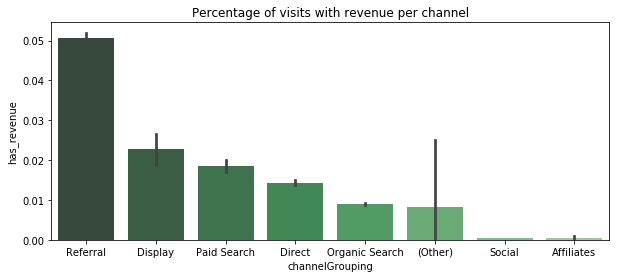

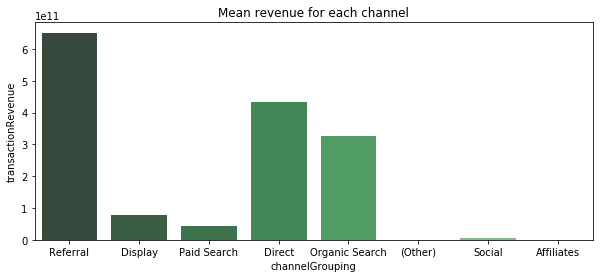

In [11]:
channel_order = ['Referral', 'Display', 'Paid Search', 'Direct', 'Organic Search', '(Other)', 'Social', 'Affiliates']
plt.figure(figsize=(10,4))
plt.title("Percentage of visits with revenue per channel")
sns.barplot(x='channelGrouping', y='has_revenue', data=train, order=channel_order, palette='Greens_d')
revenue_channel = train.groupby('channelGrouping')['transactionRevenue'].sum()
revenue_channel = revenue_channel.to_frame().reset_index()
plt.figure(figsize=(10,4))
plt.title("Mean revenue for each channel")
ax = sns.barplot(x='channelGrouping', y='transactionRevenue', data=revenue_channel, order=channel_order, palette='Greens_d')

In [14]:
def plotmap(frame, z_var, countries_col, title, colorscale, rcolor=True):
    data = [ dict(
            type = 'choropleth',
            autocolorscale = False,
            colorscale = colorscale,
            showscale = True,
            reversescale = rcolor,
            locations = frame[countries_col],
            z = frame[z_var],
            locationmode = 'country names',
            text = frame[countries_col],
            marker = dict(line = dict(color = '#fff', width = 2))
        )           
    ]

    layout = dict(
        height=680,
        #width=1200,
        title = title,
        geo = dict(
            showframe = False,
            showcoastlines = False,
            projection = dict(type = 'mercator'),
        ),
    )
    fig = dict(data=data, layout=layout)
    iplot(fig)

colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]
    
# Plot world map - total visits
tmp = train["country"].value_counts().to_frame().reset_index()
plotmap(tmp, 'country', 'index', 'Total visits by Country', colorscale, False)

colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
        [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]]
# Plot world map - mean revenue
tmp = train.groupby("country").agg({"transactionRevenue" : "mean"}).reset_index()
plotmap(tmp, 'transactionRevenue','country', 'Mean revenue by country', colorscale)
# Plot world map - total revenue
tmp = train.groupby("country").agg({"transactionRevenue" : "sum"}).reset_index()
plotmap(tmp, 'transactionRevenue','country', 'Total revenue by country', colorscale)


In [15]:
tmp1 = train["continent"].value_counts().to_frame().reset_index()
tmp2 = train.groupby("continent")["transactionRevenue"].sum().to_frame().reset_index()
fig = {
  "data": [
    {
        "values": tmp1['continent'],
        "labels": tmp1['index'],
        "name": "Visits",
        "domain": {"x": [0, 0.46]},
        "hoverinfo":"label+percent+name",
        "hole": .5,
        "type": "pie",
        #"textinfo": "none"
    },
    {
        "values": tmp2['transactionRevenue'],
        "labels": tmp2['continent'],
        "name": "Revenue",
        #"textposition":"inside",
        "domain": {"x": [.54, 1]},
        "hoverinfo":"label+percent+name",
        "hole": .5,
        "type": "pie",
        #"textinfo": "none"
    }],
  "layout": {
        "title":"Visits and Revenue by Continent",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Visits",
                "x": 0.18,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Revenue",
                "x": 0.85,
                "y": 0.5
            }
        ]
    }
}
iplot(fig, filename='donut')

In [16]:
barplot_percentage('networkDomain', num_bars= 10, 
                   color1='rgb(38, 115, 77)', color2='rgb(102, 204, 153)')

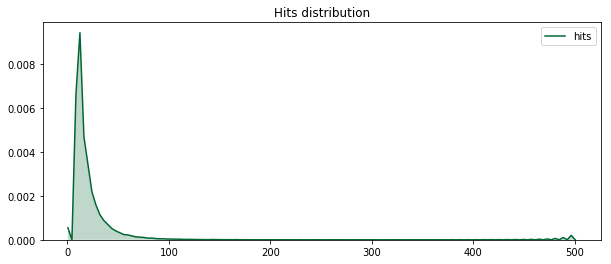

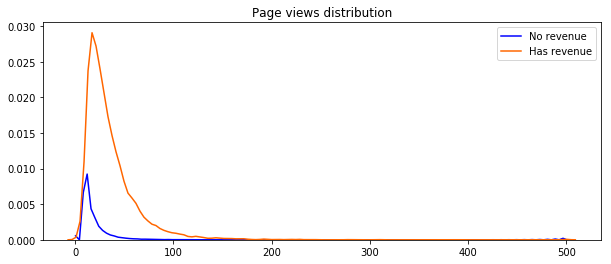

In [18]:
plt.figure(figsize=(10,4))
plt.title("Hits distribution")
ax1 = sns.kdeplot(train['hits'].astype('float64'), color="#006633", shade=True)
plt.figure(figsize=(10,4))
plt.title("Page views distribution")
ax2 = sns.kdeplot(train[train['has_revenue'] == 0]['hits'].astype('float64'),
                  label='No revenue', color="#0000ff")
ax2 = sns.kdeplot(train[train['has_revenue'] == 1]['hits'].astype('float64'),
                  label='Has revenue', color="#ff6600")

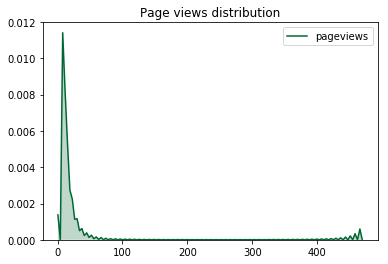

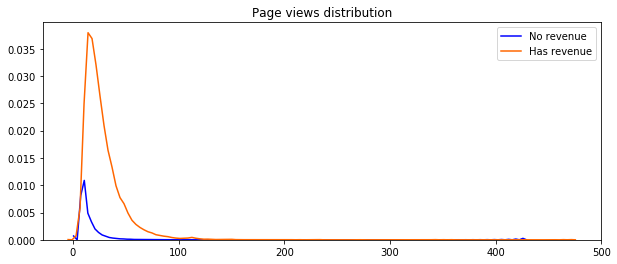

In [19]:
plt.title("Page views distribution")
ax3 = sns.kdeplot(train['pageviews'].dropna().astype('float64'), color="#006633", shade=True)
plt.figure(figsize=(10,4))
plt.title("Page views distribution")
ax4 = sns.kdeplot(train[train['has_revenue'] == 0]['pageviews'].dropna().astype('float64'),
                  label='No revenue', color="#0000ff")
ax4 = sns.kdeplot(train[train['has_revenue'] == 1]['pageviews'].dropna().astype('float64'),
                  label='Has revenue', color="#ff6600")

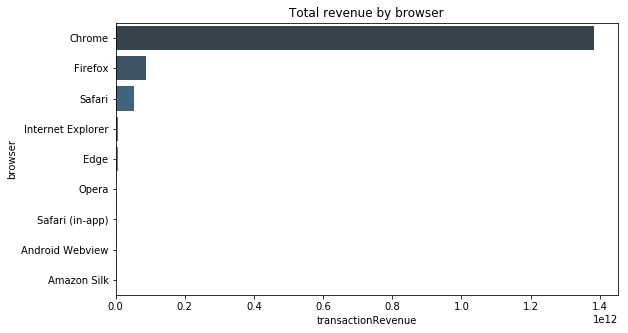

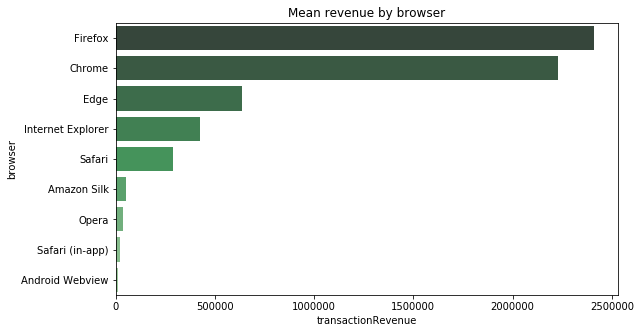

In [21]:
# Group and plot revenue
def group_revenue(group_col, title, sum_values=True, palette='Blues_d', size=(8,5)):
    if sum_values:
        tmp = train.groupby(group_col)['transactionRevenue'].sum()
    else:
        tmp = train.groupby(group_col)['transactionRevenue'].mean()
    tmp = tmp.to_frame().reset_index().sort_values('transactionRevenue', ascending=False)
    tmp = tmp[tmp['transactionRevenue'] > 0]
    plt.figure(figsize=size)
    plt.title(title)
    ax = sns.barplot(y=tmp[group_col], x= tmp.transactionRevenue, orient='h', palette=palette)
# Visits
barplot_percentage('browser', num_bars= 7)
# Revenue
group_revenue('browser', 'Total revenue by browser', True, size=(9,5))
group_revenue('browser', 'Mean revenue by browser', False, 'Greens_d',size=(9,5))

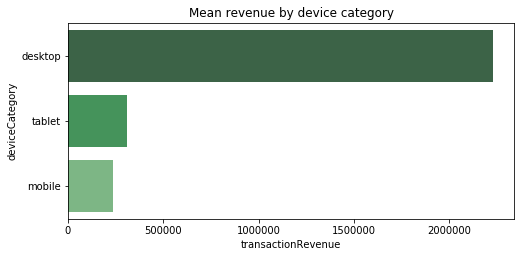

In [23]:
# Pie chart
colors = ['#5c8a8a', '#94b8b8', '#b3cccc']
dev_train = train['deviceCategory'].value_counts().to_frame().reset_index()
dev_test = test['deviceCategory'].value_counts().to_frame().reset_index()
trace1 = go.Pie(labels=dev_train['index'], values=dev_train.deviceCategory,
                domain= {'x': [0, .48]}, marker=dict(colors=colors))
trace2 = go.Pie(labels=dev_test['index'], values=dev_test.deviceCategory,
                domain= {'x': [0.52, 1]}, marker=dict(colors=colors))
layout = dict(title= "Device category - train and test", height=400)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)
# Revenue
group_revenue('deviceCategory', 'Mean revenue by device category', False, 'Greens_d', size=(8, 3.6))

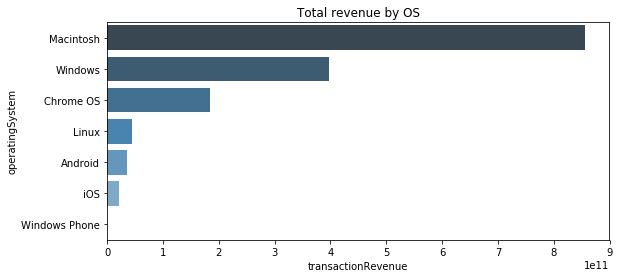

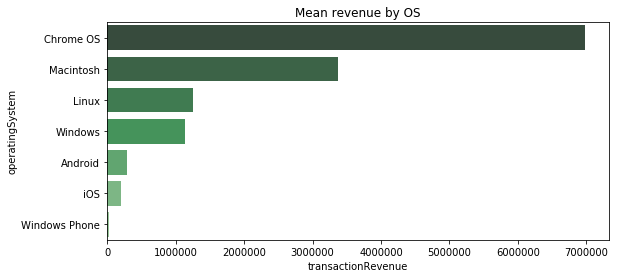

In [25]:
barplot_percentage('operatingSystem', num_bars = 7,
                   color1='rgb(204, 82, 0)', color2='rgb(255, 163, 102)')
# Revenue
group_revenue('operatingSystem', 'Total revenue by OS', True, 'Blues_d', size=(9, 4))
group_revenue('operatingSystem', 'Mean revenue by OS', False, 'Greens_d', size=(9, 4))

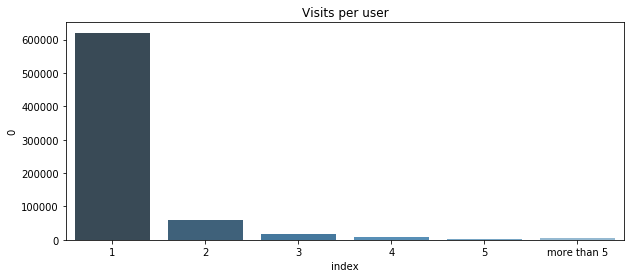

In [26]:
tmp = train.groupby('fullVisitorId').size().value_counts().to_frame().reset_index()
sum_ = tmp[tmp['index'].astype('int16') > 5][0].sum()
tmp = tmp.head(5).append(pd.DataFrame({'index': ['more than 5'], 0: [sum_]})).reset_index()
plt.figure(figsize=(10,4))
plt.title("Visits per user")
ax = sns.barplot(x=tmp['index'], y=tmp[0], palette='Blues_d')

In [28]:
def getbin_hits(x):
    if x < 5:
        return "1-5"
    elif x < 10:
        return "5-10"
    elif x < 30:
        return "10-30"
    elif x < 50:
        return "30-50"
    elif x < 100:
        return "50-100"
    else:
        return "100+"

agg_dict = {}
for col in ["bounces", "hits", "newVisits", "pageviews", "transactionRevenue"]:
    train[col] = train[col].astype('float')
    agg_dict[col] = "sum"
tmp = train.groupby("fullVisitorId").agg(agg_dict).reset_index()
tmp["total_hits_bin"] = tmp["hits"].apply(getbin_hits)
tmp["totals_bounces_bin"] = tmp["bounces"].apply(lambda x : str(x) if x <= 5 else "5+")
tmp["totals_pageviews_bin"] = tmp["pageviews"].apply(lambda x : str(x) if x <= 50 else "50+")

t1 = tmp["total_hits_bin"].value_counts()
t2 = tmp["totals_bounces_bin"].value_counts()
t3 = tmp["newVisits"].value_counts()
t4 = tmp["totals_pageviews_bin"].value_counts()

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=["Total Hits per User", "Total Bounces per User", 
                                                         "Total NewVisits per User", "Total PageViews per User"], print_grid=False)

tr1 = go.Bar(x = t1.index[:20], y = t1.values[:20])
tr2 = go.Bar(x = t2.index[:20], y = t2.values[:20])
tr3 = go.Bar(x = t3.index[:20], y = t3.values[:20])
tr4 = go.Bar(x = t4.index, y = t4.values)

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig.append_trace(tr3, 2, 1)
fig.append_trace(tr4, 2, 2)

fig['layout'].update(height=700, showlegend=False)
iplot(fig)

/Users/drucila/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [33]:
def plotbar(df, col, title, top=None):
    frame = pd.DataFrame()
    frame['transactionRevenue'] = df['transactionRevenue'].copy()
    frame[col] = df[col].fillna('missing')
    # Percentage of revenue
    tmp_rev = frame.groupby(col)['transactionRevenue'].sum().to_frame().reset_index()
    tmp_rev = tmp_rev.sort_values('transactionRevenue', ascending=False)
    tmp_rev = tmp_rev.rename({'transactionRevenue': 'Revenue percentage'},axis=1)
    tmp_rev['Revenue percentage'] = 100*tmp_rev['Revenue percentage']/df['transactionRevenue'].sum()
    # Percentage of visits
    tmp = frame[col].value_counts().to_frame().reset_index()
    tmp.sort_values(col, ascending=False)
    tmp = tmp.rename({'index': col, col: 'Percentage of Visits'},axis=1)
    tmp['Percentage of Visits'] = 100*tmp['Percentage of Visits']/len(df)
    tmp = pd.merge(tmp, tmp_rev, on=col, how='left')
    if top:
        tmp = tmp.head(top)
    # Barplot
    trace1 = go.Bar(x=tmp[col], y=tmp['Percentage of Visits'],
                    name='Visits', marker=dict(color='rgb(55, 83, 109)'))
    trace2 = go.Bar(x=tmp[col], y=tmp['Revenue percentage'],
                    name='Revenue', marker=dict(color='rgb(26, 118, 255)'))

    layout = go.Layout(
        barmode='group',
        title=title,
    )
    
    layout = go.Layout(
        title=title,
        xaxis=dict(tickfont=dict(size=14, color='rgb(107, 107, 107)')),
        yaxis=dict(
            title='Percentage',
            titlefont=dict(size=16, color='rgb(107, 107, 107)'),
            tickfont=dict(size=14, color='rgb(107, 107, 107)')
        ),
        legend=dict(x=0.95, y=1.0, bgcolor='rgba(255, 255, 255, 0)',
                    bordercolor='rgba(255, 255, 255, 0)'),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1
    )
    
    fig = go.Figure(data=[trace1, trace2], layout=layout)
    iplot(fig)
    
plotbar(train, 'medium', 'Train set - visits and revenue by medium')

In [34]:
plotbar(train[train['medium'] == 'organic'], 'source', 'Visits and revenue by source for Organic search')

In [35]:
def print_value_counts(category):
    cols = ['adContent', 
           'referralPath', 'campaign']
    for c in cols:
        nunique = train[train['medium'] == category][c].nunique()
        if nunique < 5:
            print(train[train['medium'] == category][c].value_counts(dropna=False))
        else:
            print(train[train['medium'] == category][c].describe())
            
print_value_counts('organic')

NaN    234381
Name: adContent, dtype: int64
NaN    234381
Name: referralPath, dtype: int64
(not set)    234381
Name: campaign, dtype: int64


In [36]:
plotbar(train[train['medium'] == 'referral'], 'source', 'Visits and revenue by source for Referral', top=8)

In [37]:
print_value_counts('referral')

NaN    262022
Name: adContent, dtype: int64
count         262008
unique          1424
top       /yt/about/
freq           71036
Name: referralPath, dtype: object
(not set)    262022
Name: campaign, dtype: int64


In [38]:
plotbar(train[train['medium'] == 'referral'], 'channelGrouping', 'Visits and revenue by channel for REFERRAL MEDIUM')

In [39]:
plotbar(train[train['medium'] == 'cpc'], 'source', 'Visits and revenue by source for CPC', top=None)

In [40]:
print_value_counts('cpc')

count                              6785
unique                               38
top       Google Merchandise Collection
freq                               4052
Name: adContent, dtype: object
NaN    13079
Name: referralPath, dtype: int64
count                                  13079
unique                                     6
top       AW - Dynamic Search Ads Whole Site
freq                                    6213
Name: campaign, dtype: object


In [41]:
plotbar(train[train['medium'] == 'cpc'], 'campaign', 'Visits and revenue by campaign for CPC')

In [42]:
plotbar(train[train['medium'] == 'cpm'], 'source', 'Visits and revenue by source for CPM')

In [43]:
print_value_counts('cpm')

NaN    6184
Name: adContent, dtype: int64
NaN    6184
Name: referralPath, dtype: int64
(not set)    6184
Name: campaign, dtype: int64


In [44]:
print_value_counts('affiliate')

NaN               16402
GA Help Center        1
Name: adContent, dtype: int64
NaN    16403
Name: referralPath, dtype: int64
Data Share Promo    16402
Data Share              1
Name: campaign, dtype: int64


In [45]:
print_value_counts('(none)')

count                              4160
unique                               35
top       Google Merchandise Collection
freq                               1070
Name: adContent, dtype: object
count     68933
unique       59
top           /
freq      67236
Name: referralPath, dtype: object
(not set)    371467
Name: campaign, dtype: int64


In [ ]:
### def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    df['visitStartTime_'] = pd.to_datetime(df['visitStartTime'],unit="s")
    df['visitStartTime_year'] = df['visitStartTime_'].apply(lambda x: x.year)
    df['visitStartTime_month'] = df['visitStartTime_'].apply(lambda x: x.month)
    df['visitStartTime_day'] = df['visitStartTime_'].apply(lambda x: x.day)
    df['visitStartTime_weekday'] = df['visitStartTime_'].apply(lambda x: x.weekday())
    return df
date_features = [#"year","month","day","weekday",'visitStartTime_year',
    "visitStartTime_month","visitStartTime_day","visitStartTime_weekday"]

In [10]:
train_df.dtypes

channelGrouping               object
date                           int64
fullVisitorId                 object
socialEngagementType          object
visitId                        int64
visitNumber                    int64
visitStartTime                 int64
browser                       object
browserSize                   object
browserVersion                object
deviceCategory                object
flashVersion                  object
isMobile                        bool
language                      object
mobileDeviceBranding          object
mobileDeviceInfo              object
mobileDeviceMarketingName     object
mobileDeviceModel             object
mobileInputSelector           object
operatingSystem               object
operatingSystemVersion        object
screenColors                  object
screenResolution              object
city                          object
cityId                        object
continent                     object
country                       object
l

Text(0.5, 1.0, 'type of train data')

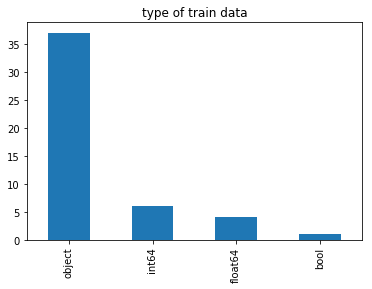

In [11]:
pd.value_counts(train_df.dtypes).plot(kind="bar")
plt.title("type of train data")

In [12]:
def bar_plot(column,**args):
    pd.value_counts(train_df[column]).plot(kind="bar",**args)
    

Removing Constant Columns

In [13]:
constant_column = [col for col in train_df.columns if len(train_df[col].unique()) == 1]
print(list(constant_column))
train_df.drop(columns=constant_column,inplace=True)

['socialEngagementType', 'browserSize', 'browserVersion', 'flashVersion', 'language', 'mobileDeviceBranding', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel', 'mobileInputSelector', 'operatingSystemVersion', 'screenColors', 'screenResolution', 'cityId', 'latitude', 'longitude', 'networkLocation', 'visits']


In [16]:
num_col = ["hits", "pageviews", "visitNumber", 
           'bounces',  'newVisits']

In [17]:
for col in num_col:
    train_df[col] = train_df[col].fillna("0").astype("int32")
    test_df[col] = test_df[col].fillna("0").astype("int32")

In [18]:
train_df.dtypes

channelGrouping        object
date                    int64
fullVisitorId          object
visitId                 int64
visitNumber             int32
visitStartTime          int64
browser                object
deviceCategory         object
isMobile                 bool
operatingSystem        object
city                   object
continent              object
country                object
metro                  object
networkDomain          object
region                 object
subContinent           object
bounces                 int32
hits                    int32
newVisits               int32
pageviews               int32
transactionRevenue    float64
adContent              object
campaign               object
campaignCode           object
isTrueDirect           object
keyword                object
medium                 object
referralPath           object
source                 object
dtype: object

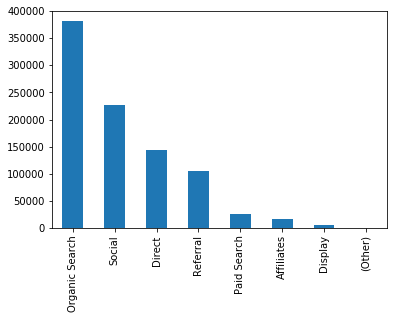

In [19]:
bar_plot("channelGrouping")

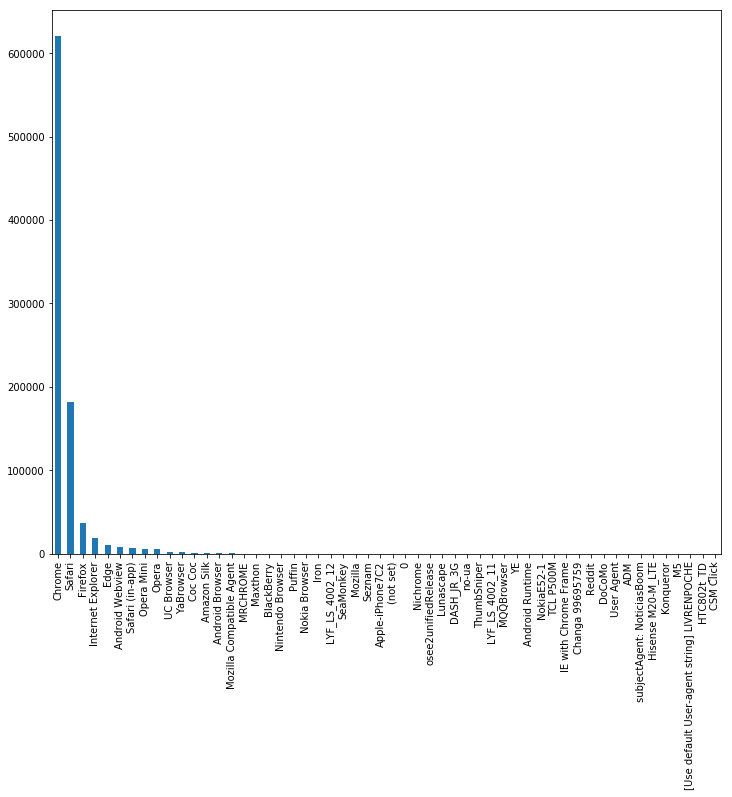

In [20]:
bar_plot("browser",figsize=(12,10))

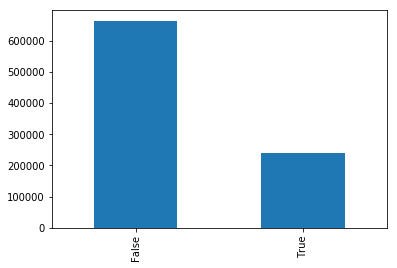

In [21]:
bar_plot("isMobile")

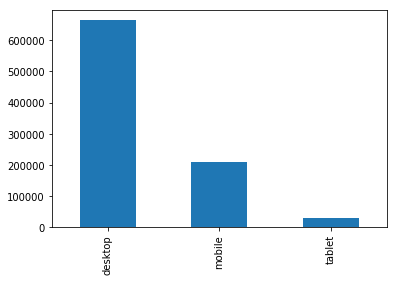

In [22]:
bar_plot("deviceCategory")

Feature Engineering

In [23]:
new_features = ["hits_per_pageviews"]
new_category_features = ["is_high_hits"]
def feature_engineering(df):
    line = 4
    df['hits_per_pageviews'] = (df["hits"]/(df["pageviews"])).apply(lambda x: 0 if np.isinf(x) else x)
    df['is_high_hits'] = np.logical_or(train_df["hits"]>line,train_df["pageviews"]>line).astype(np.int32)

In [24]:
feature_engineering(train_df)
feature_engineering(test_df)
add_time_features(train_df)
_ = add_time_features(test_df)

In [28]:
category_features = ["channelGrouping", "browser", 
            "deviceCategory", "operatingSystem", 
            "city", "continent", 
            "country", "metro",
            "networkDomain", "region", 
            "subContinent",
            "medium", 
            "source",
            'isTrueDirect',
            ] + date_features
target = 'transactionRevenue'
useless_col = ["adContent", 
              "campaign",
              "referralPath",
              "keyword"]

In [29]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,...,is_high_hits,year,month,day,weekday,visitStartTime_,visitStartTime_year,visitStartTime_month,visitStartTime_day,visitStartTime_weekday
0,Organic Search,2017-07-02,0025693546458698359,1498999998,5,1498999998,Safari,desktop,False,Macintosh,...,0,2017,7,2,6,2017-07-02 12:53:18,2017,7,2,6
1,Organic Search,2017-07-02,8622165649169477418,1499006908,1,1499006908,Chrome,desktop,False,Windows,...,0,2017,7,2,6,2017-07-02 14:48:28,2017,7,2,6
2,Organic Search,2017-07-02,2856336439798426805,1499047740,1,1499047740,Chrome,mobile,True,Android,...,0,2017,7,2,6,2017-07-03 02:09:00,2017,7,3,0
3,Organic Search,2017-07-02,4203774291422453000,1499065071,1,1499065071,Chrome,mobile,True,Android,...,0,2017,7,2,6,2017-07-03 06:57:51,2017,7,3,0
4,Organic Search,2017-07-02,9372927630225043132,1499018422,1,1499018422,Chrome,desktop,False,Windows,...,0,2017,7,2,6,2017-07-02 18:00:22,2017,7,2,6


In [30]:
useless_df = train_df[useless_col]
useless_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 4 columns):
adContent       10946 non-null object
campaign        903653 non-null object
referralPath    330941 non-null object
keyword         241905 non-null object
dtypes: object(4)
memory usage: 27.6+ MB


In [31]:
for col in useless_col:
    print("-"*10,col,"-"*10)
    print("unique value numbers:",len(useless_df[col].unique()))
    print("null rate:",useless_df[col].isna().sum()/len(useless_df[col]))

---------- adContent ----------
unique value numbers: 45
null rate: 0.9878869433289106
---------- campaign ----------
unique value numbers: 8
null rate: 0.0
---------- referralPath ----------
unique value numbers: 1476
null rate: 0.6337742474157669
---------- keyword ----------
unique value numbers: 2718
null rate: 0.732303218160068


In [32]:
for col in category_features:
    print("-"*10,col,"-"*10)
    print("unique value numbers:",len(train_df[col].unique()))
    print("null rate:",train_df[col].isna().sum()/len(train_df[col]))

---------- channelGrouping ----------
unique value numbers: 8
null rate: 0.0
---------- browser ----------
unique value numbers: 54
null rate: 0.0
---------- deviceCategory ----------
unique value numbers: 3
null rate: 0.0
---------- operatingSystem ----------
unique value numbers: 20
null rate: 0.0
---------- city ----------
unique value numbers: 649
null rate: 0.0
---------- continent ----------
unique value numbers: 6
null rate: 0.0
---------- country ----------
unique value numbers: 222
null rate: 0.0
---------- metro ----------
unique value numbers: 94
null rate: 0.0
---------- networkDomain ----------
unique value numbers: 28064
null rate: 0.0
---------- region ----------
unique value numbers: 376
null rate: 0.0
---------- subContinent ----------
unique value numbers: 23
null rate: 0.0
---------- medium ----------
unique value numbers: 7
null rate: 0.0
---------- source ----------
unique value numbers: 275
null rate: 0.0
---------- isTrueDirect ----------
unique value numbers: 2


In [33]:
train_df[target] = train_df[target].fillna("0").astype("int32")

In [34]:
all_features = category_features+num_col+new_features+new_category_features
all_features

['channelGrouping',
 'browser',
 'deviceCategory',
 'operatingSystem',
 'city',
 'continent',
 'country',
 'metro',
 'networkDomain',
 'region',
 'subContinent',
 'medium',
 'source',
 'isTrueDirect',
 'visitStartTime_month',
 'visitStartTime_day',
 'visitStartTime_weekday',
 'hits',
 'pageviews',
 'visitNumber',
 'bounces',
 'newVisits',
 'hits_per_pageviews',
 'is_high_hits']

In [35]:
train_df["hits"].describe()

count    903653.000000
mean          4.596538
std           9.641437
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         500.000000
Name: hits, dtype: float64

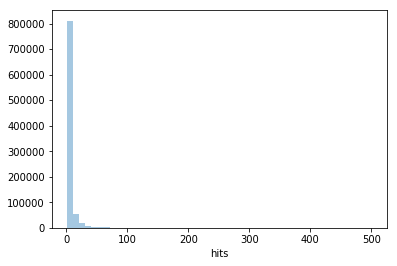

In [36]:
sns.distplot(train_df["hits"],kde=False)

In [38]:
train_df["pageviews"].describe()

count    903653.000000
mean          3.849338
std           7.025002
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         469.000000
Name: pageviews, dtype: float64

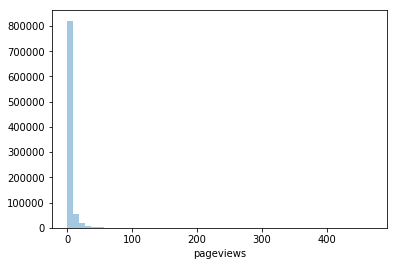

In [39]:
sns.distplot(train_df["pageviews"],kde=False)

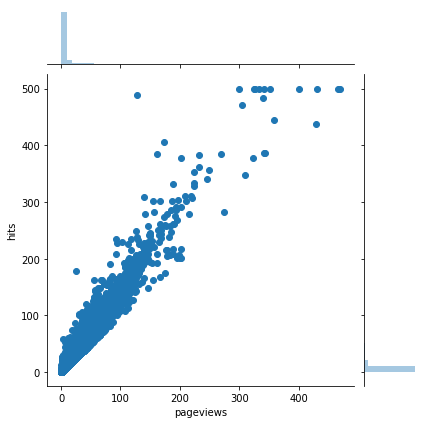

In [40]:
sns.jointplot("pageviews","hits",data=train_df)

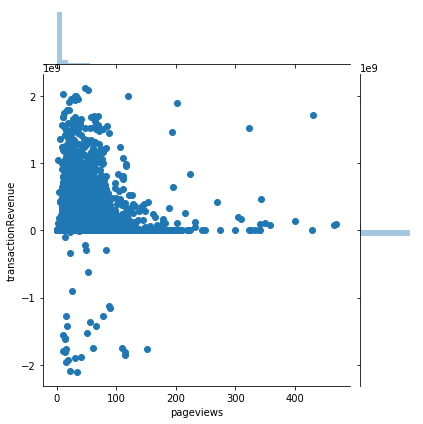

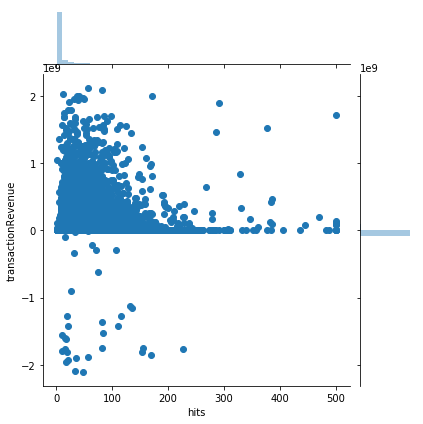

In [41]:
sns.jointplot("pageviews",target,data=train_df)
sns.jointplot("hits",target,data=train_df)

In [43]:
line = 4
high_hits_pageviews_df = train_df[np.logical_or(train_df["hits"]>line,train_df["pageviews"]>line)]
low_hits_pageviews_df = train_df[np.logical_and(train_df["hits"]<=line,train_df["pageviews"]<=line)]

In [44]:
print("high rate :",high_hits_pageviews_df.shape[0]/train_df.shape[0])
print("low rate :",low_hits_pageviews_df.shape[0]/train_df.shape[0])

high rate : 0.22807537849152273
low rate : 0.7719246215084773


In [45]:
high_hits_pageviews_df[target].describe()

count    2.061010e+05
mean     6.251999e+06
std      5.833043e+07
min     -2.099967e+09
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.110800e+09
Name: transactionRevenue, dtype: float64

In [46]:
low_hits_pageviews_df[target].describe()

count    6.975520e+05
mean     3.469247e+03
std      1.475363e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.052000e+09
Name: transactionRevenue, dtype: float64

Text(0.5, 1.0, 'distribution of low hits transactionRevenue')

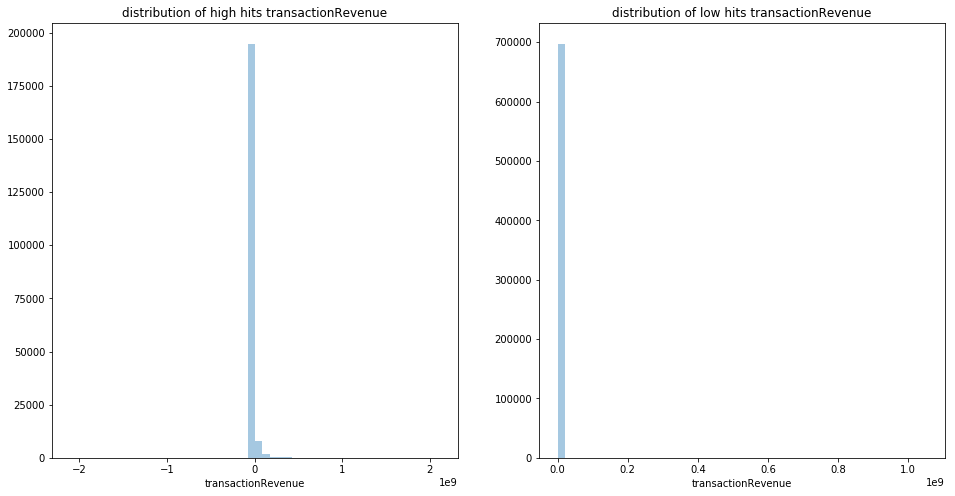

In [47]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(16,8))
sns.distplot(high_hits_pageviews_df[target],kde=False,ax=axes[0])
axes[0].set_title("distribution of high hits transactionRevenue")

sns.distplot(low_hits_pageviews_df[target],kde=False,ax=axes[1])
axes[1].set_title("distribution of low hits transactionRevenue")

In [48]:
print("zero rate of transactionRevenue:",(train_df[target]==0).sum()/train_df.shape[0])
print("zero rate of high hits transactionRevenue:",(high_hits_pageviews_df[target]==0).sum()/ high_hits_pageviews_df.shape[0])
print("zero rate of low hits transactionRevenue:",(low_hits_pageviews_df[target]==0).sum()/ low_hits_pageviews_df.shape[0])

zero rate of transactionRevenue: 0.9872572768529513
zero rate of high hits transactionRevenue: 0.9442021144972611
zero rate of low hits transactionRevenue: 0.9999784962268046


In [49]:
train_df["hits_per_pageviews"].describe()


count    903653.000000
mean          1.073223
std           0.210148
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          26.000000
Name: hits_per_pageviews, dtype: float64

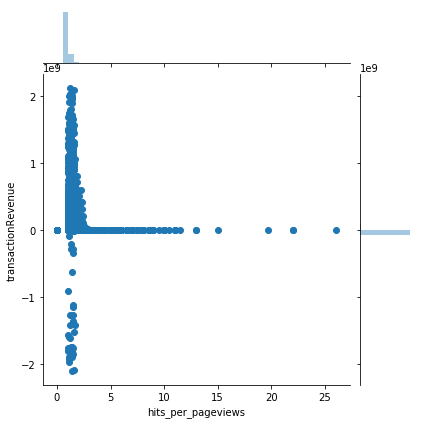

In [50]:
sns.jointplot("hits_per_pageviews",target,data=train_df)

In [51]:
visitStartTime_df = train_df[["visitStartTime",'visitStartTime_year',"visitStartTime_month","visitStartTime_day","visitStartTime_weekday",target]]
visitStartTime_df["visitStartTime"] = pd.to_datetime(visitStartTime_df["visitStartTime"],unit="s")
visitStartTime_df["visitStartDate"] = visitStartTime_df["visitStartTime"].apply(lambda x: x.date())


In [52]:
def plot_dist_date(col,kind="bar"):
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
    visitStartTime_df.groupby(col)[target].agg(["sum"]).plot(kind=kind,title="sum of transactionRevenue:"+col,ax=axes[0])
    visitStartTime_df.groupby(col)[target].agg(["count"]).plot(kind=kind,title="count of transactionRevenue:"+col,ax=axes[1])
    plt.tight_layout()


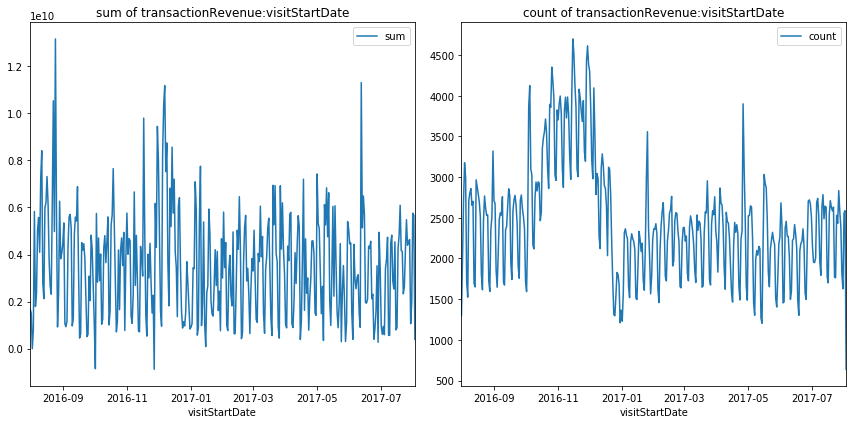

In [53]:
plot_dist_date("visitStartDate",kind="line")

In [54]:
test_visitStartTime_df = test_df[["visitStartTime",'visitStartTime_year',"visitStartTime_month","visitStartTime_day","visitStartTime_weekday"]]
test_visitStartTime_df["visitStartTime"] = pd.to_datetime(test_visitStartTime_df["visitStartTime"],unit="s")
test_visitStartTime_df["visitStartDate"] = test_visitStartTime_df["visitStartTime"].apply(lambda x: x.date())

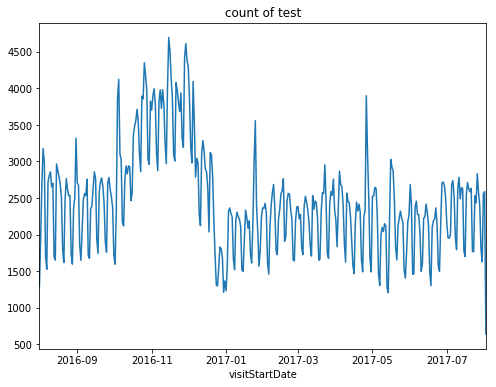

In [55]:
test_visitStartTime_df.groupby("visitStartDate")["visitStartTime"].agg("count").plot(figsize=(8,6),title="count of test")

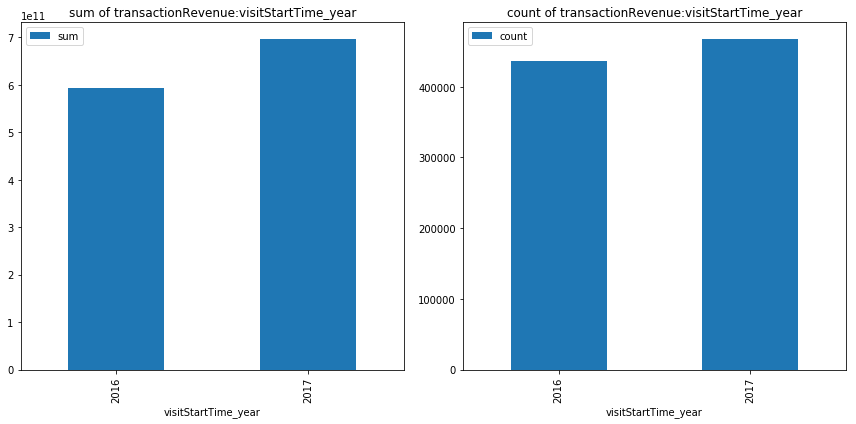

In [56]:
plot_dist_date("visitStartTime_year")

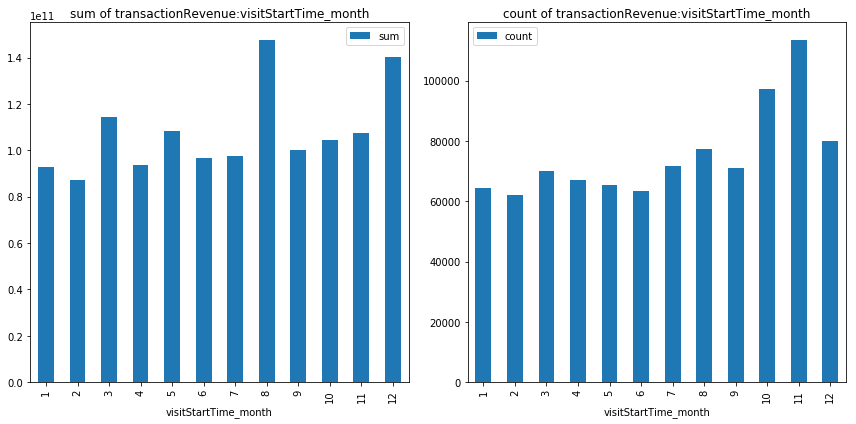

In [57]:
plot_dist_date("visitStartTime_month")

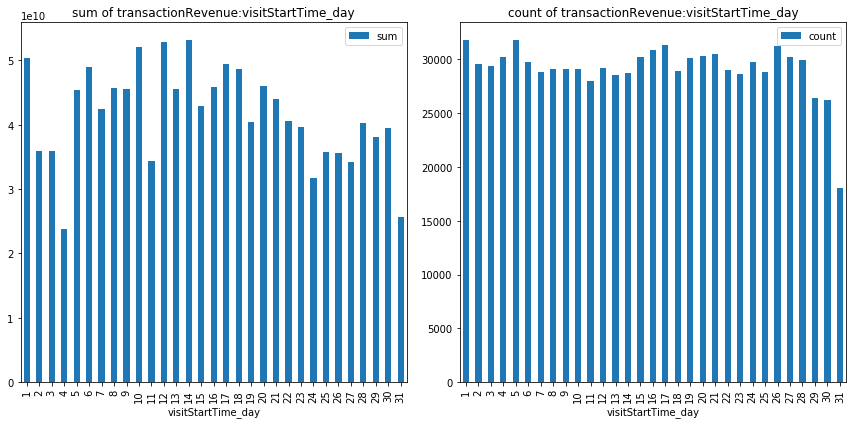

In [58]:
plot_dist_date("visitStartTime_day")

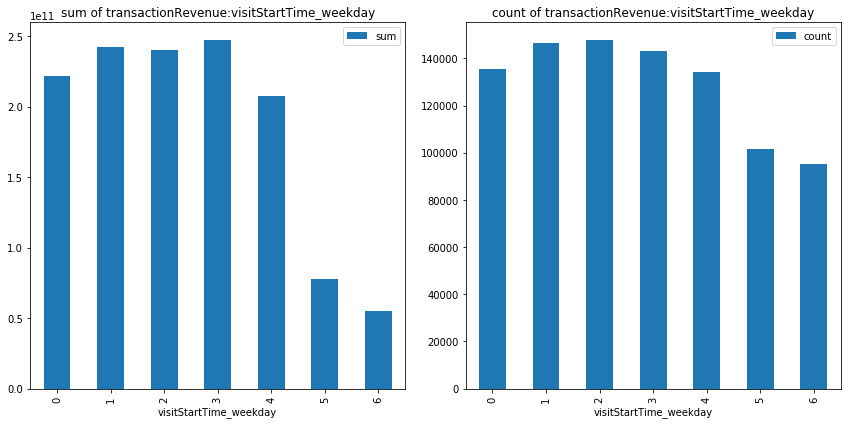

In [59]:
plot_dist_date("visitStartTime_weekday")

In [60]:
col = "trafficSource.cleanedkeyword"
train_df[col] = train_df["keyword"].apply(lambda x :x if isinstance(x,float) and np.isnan(x) else x.lower()).apply(lambda x :x if isinstance(x,float) and np.isnan(x) else x.replace("+", ""))
test_df[col] = test_df["keyword"].apply(lambda x :x if isinstance(x,float) and np.isnan(x) else x.lower())
print("-"*10,"train","-"*10)
print("unique value numbers:",len(train_df[col].unique()))
print("null rate:",train_df[col].isna().sum()/len(train_df[col]))
print("-"*10,"test","-"*10)
print("unique value numbers:",len(test_df[col].unique()))
print("null rate:",test_df[col].isna().sum()/len(test_df[col]))


---------- train ----------
unique value numbers: 2498
null rate: 0.732303218160068
---------- test ----------
unique value numbers: 2533
null rate: 0.732303218160068


In [61]:
pd.value_counts(train_df[col]).sort_values(ascending=False)[0:20]

(not provided)                             222542
6qehscssdk0z36ri                             4649
google merchandise store                     2091
google merchandise                           1848
1hzbaqlcbjwfgoh7                             1258
google store                                 1127
(remarketing/content targeting)               886
youtube                                       668
1x4me6zknv0zg-jv                              297
youtube merchandise                           240
youtube merch                                 231
google merch                                  196
(user vertical targeting)                     157
https://www.googlemerchandisestore.com/       120
google shop                                   115
you tube                                      111
(automatic matching)                          110
google store merchandise                      104
google online store                            86
google products                                86


In [62]:
pd.value_counts(test_df[col]).sort_values(ascending=False)[0:20]

(not provided)                             222542
6qehscssdk0z36ri                             4649
google merchandise store                     1890
google merchandise                           1586
1hzbaqlcbjwfgoh7                             1258
(remarketing/content targeting)               886
google store                                  878
youtube                                       668
1x4me6zknv0zg-jv                              297
+google +merchandise                          262
+google +store                                249
+google +merchandise +store                   201
youtube merchandise                           186
youtube merch                                 162
(user vertical targeting)                     157
google merch                                  156
https://www.googlemerchandisestore.com/       120
you tube                                      111
(automatic matching)                          110
google shop                                   105


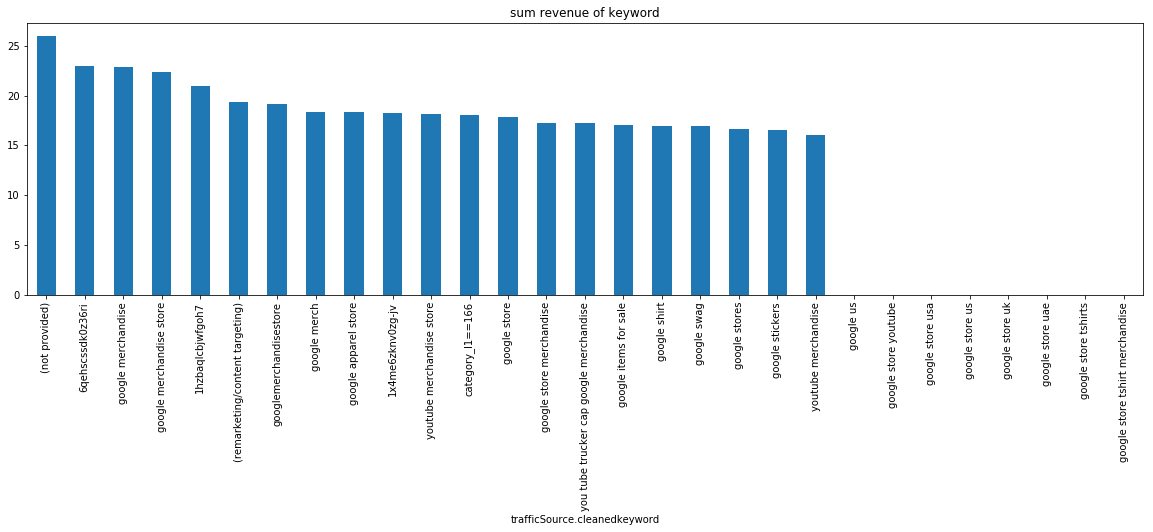

In [63]:
train_df.groupby(col)[target].agg("sum").sort_values(ascending=False)[0:29].apply(lambda x: np.log1p(x)).plot(kind="bar",figsize=(20,5),title="sum revenue of keyword")

In [64]:
none_zero_keywords= set(train_df.groupby(col)[target].agg("sum").sort_values(ascending=False)[0:28].index)
test_keywords_set = set(test_df[col].unique())
intersection_keyword = none_zero_keywords.intersection(test_keywords_set)
print("len:",len(intersection_keyword))
intersection_keyword

len: 27


{'(not provided)',
 '(remarketing/content targeting)',
 '1hzbaqlcbjwfgoh7',
 '1x4me6zknv0zg-jv',
 '6qehscssdk0z36ri',
 'category_l1==166',
 'google apparel store',
 'google items for sale',
 'google merch',
 'google merchandise',
 'google merchandise store',
 'google shirt',
 'google stickers',
 'google store',
 'google store merchandise',
 'google store tshirts',
 'google store uae',
 'google store uk',
 'google store us',
 'google store usa',
 'google store youtube',
 'google stores',
 'google us',
 'googlemerchandisestore',
 'you tube trucker cap google merchandise',
 'youtube merchandise',
 'youtube merchandise store'}

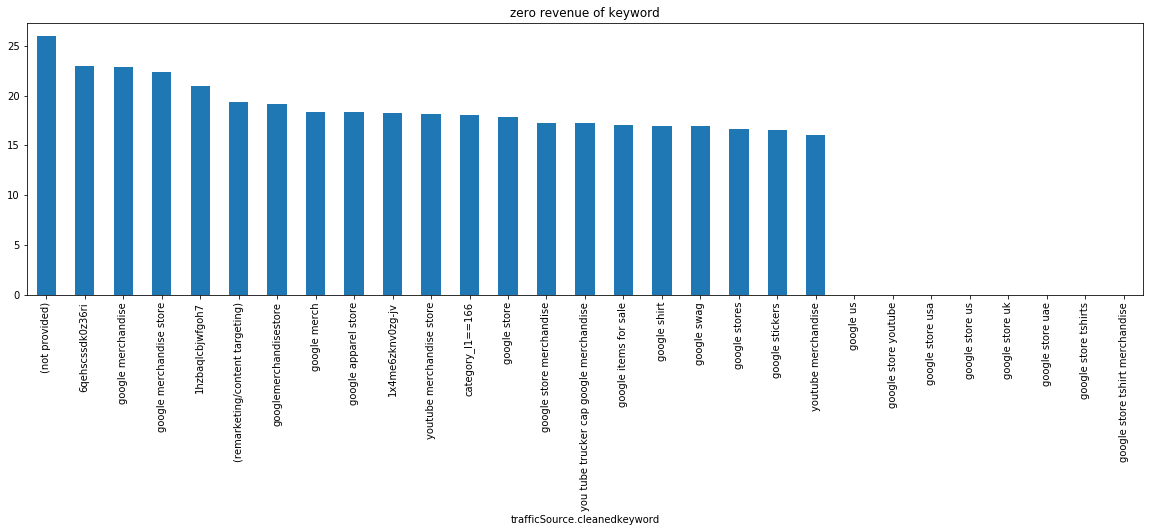

In [65]:
train_df.groupby(col)[target].agg("sum").sort_values(ascending=False)[0:29].apply(lambda x: np.log1p(x)).plot(kind="bar",figsize=(20,5),title="zero revenue of keyword")

In [67]:
def add_keyword_feature(df):
    col_name ="filtered_keyword"
    sets = intersection_keyword.difference({'(automatic matching)',
     '(not provided)',
     '(remarketing/content targeting)'})
    df[col_name] = df[col].apply(lambda x: x if x in sets else "other")
add_keyword_feature(train_df)
add_keyword_feature(test_df)

In [68]:
none_zero_keywords.difference(test_keywords_set)

{'google swag'}

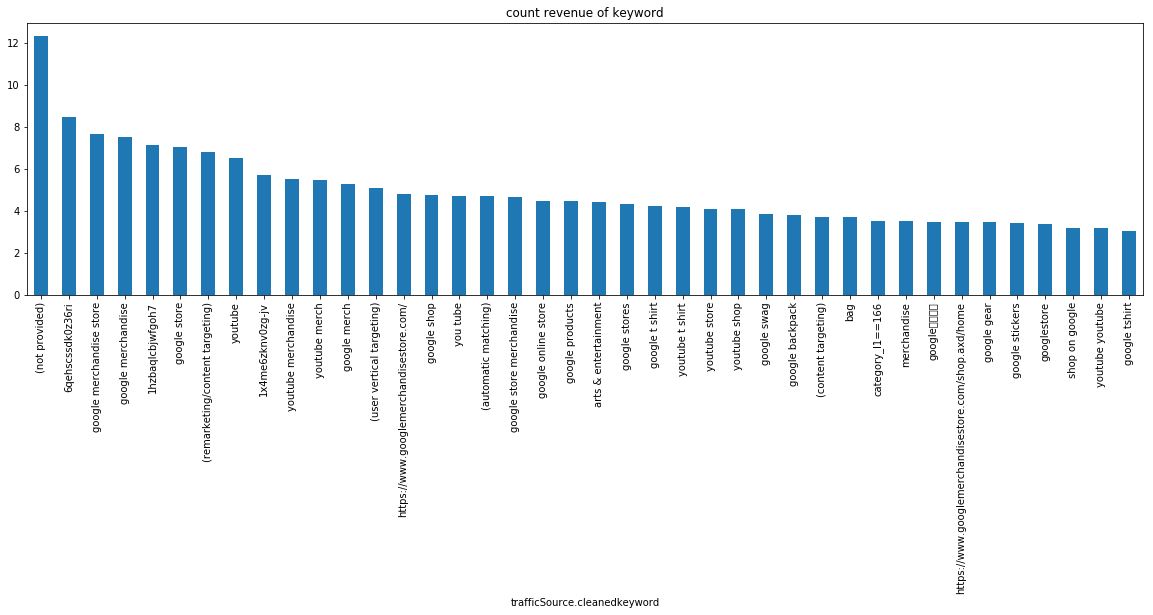

In [69]:
train_df.groupby(col)[target].agg("count").sort_values(ascending=False)[0:40].apply(lambda x: np.log1p(x)).plot(kind="bar",figsize=(20,5),title="count revenue of keyword")

In [70]:
train_x = train_df[all_features]
train_y = train_df[target]
test_x = test_df[all_features]
for col in category_features:
    print("transform column {}".format(col))
    lbe = LabelEncoder()
    lbe.fit(pd.concat([train_df[col],test_x[col]]).astype("str"))
    train_x[col] = lbe.transform(train_x[col].astype("str"))
    test_x[col] = lbe.transform(test_x[col].astype("str"))

transform column channelGrouping
transform column browser
transform column deviceCategory
transform column operatingSystem
transform column city
transform column continent
transform column country
transform column metro
transform column networkDomain
transform column region
transform column subContinent
transform column medium
transform column source
transform column isTrueDirect
transform column visitStartTime_month
transform column visitStartTime_day
transform column visitStartTime_weekday


In [71]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples,bagging_fraction,feature_fraction):
    params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 4,
    "min_child_samples" : int(min_child_samples),
    "learning_rate" : 0.03,
    "bagging_fraction" : bagging_fraction,
    "feature_fraction" : feature_fraction,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1
    }
    lgtrain = lgb.Dataset(train_x, label=np.log1p(train_y.apply(lambda x : 0 if x < 0 else x)),categorical_feature=category_features)
    cv_result = lgb.cv(params,
                       lgtrain,
                       10000,
                       categorical_feature=category_features,
                       early_stopping_rounds=100,
                       stratified=False,
                       nfold=5)
    return -cv_result['rmse-mean'][-1]

In [72]:
def lgb_train(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples,bagging_fraction,feature_fraction):
    params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 4,
    "min_child_samples" : int(min_child_samples),
    "learning_rate" : 0.01,
    "bagging_fraction" : bagging_fraction,
    "feature_fraction" : feature_fraction,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1
    }
    t_x,v_x,t_y,v_y = train_test_split(train_x,train_y,test_size=0.2)
    lgtrain = lgb.Dataset(t_x, label=np.log1p(t_y.apply(lambda x : 0 if x < 0 else x)),categorical_feature=category_features)
    lgvalid = lgb.Dataset(v_x, label=np.log1p(v_y.apply(lambda x : 0 if x < 0 else x)),categorical_feature=category_features)
    model = lgb.train(params, lgtrain, 2000, valid_sets=[lgvalid], early_stopping_rounds=100, verbose_eval=100)
    pred_test_y = model.predict(test_x, num_iteration=model.best_iteration)
    return pred_test_y, model
    
def param_tuning(init_points,num_iter,**args):
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (25, 50),
                                                'max_depth': (5, 15),
                                                'lambda_l2': (0.0, 0.05),
                                                'lambda_l1': (0.0, 0.05),
                                                'bagging_fraction': (0.5, 0.8),
                                                'feature_fraction': (0.5, 0.8),
                                                'min_child_samples': (20, 50),
                                                })

    lgbBO.maximize(init_points=init_points, n_iter=num_iter,**args)
    return lgbBO

In [73]:
result = param_tuning(5,15)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.607    |  0.6073   |  0.663    |  0.0414   |  0.03735  |  11.58    |  44.86    |  26.63    |
|  2        | -1.606    |  0.6333   |  0.7491   |  0.009102 |  0.03597  |  11.62    |  20.07    |  46.98    |
|  3        | -1.609    |  0.5683   |  0.6715   |  0.002916 |  0.04722  |  7.856    |  35.18    |  33.0     |
|  4        | -1.607    |  0.5845   |  0.7205   |  0.02238  |  0.02488  |  11.19    |  36.56    |  33.52    |
|  5        | -1.606    |  0.7789   |  0.6009   |  0.02175  |  0.01469  |  8.11     |  47.43    |  34.87    |
|  6        | -1.607    |  0.515    |  0.5429   |  0.04384  |  0.02032  |  14.92    |  20.1     |  49.65    |
|  7        | -1.615    |  0.6766   |  0.6741   |  0.047    |  0.04947  |  5.328    |  49.77    |  49.98    |
|  8      